In [43]:
!pip install imblearn shap

In [44]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.calibration import LabelEncoder
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance
from sklearn.discriminant_analysis import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from scipy.stats import variation
from sklearn.impute import KNNImputer

In [45]:
shap.initjs()

In [46]:
# Hyperparameters for various functions
seed = 0
smote_sample_strategy = 0.5
random_under_sample_strategy = 0.9
smote_k_neighbors = 5
k_features = 5

In [47]:
root_dir = os.path.dirname(os.getcwd())
df = pd.read_csv(os.path.join(root_dir, "data/processed/data_cleaned.csv"))

/tmp/ipykernel_209744/2404526448.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(root_dir, "data/processed/data_cleaned.csv"))


In [48]:
df.head()

,subject,gender,age,hand,x_coordinate,y_coordinate,timestamp,state,date,azimuth,altitude,pressure,control,session
0,T001,NaN,NaN,R,1493,9752,2098403,1,1970-01-01 12:34:58.403000,1990,720,6,N,u00005s00001_hw00001.svc
1,T001,NaN,NaN,R,1490,9752,2098411,1,1970-01-01 12:34:58.411000,1990,720,168,N,u00005s00001_hw00001.svc
2,T001,NaN,NaN,R,1490,9752,2098418,1,1970-01-01 12:34:58.418000,1990,720,328,N,u00005s00001_hw00001.svc
3,T001,NaN,NaN,R,1490,9752,2098426,1,1970-01-01 12:34:58.426000,1990,720,480,N,u00005s00001_hw00001.svc
4,T001,NaN,NaN,R,1489,9752,2098433,1,1970-01-01 12:34:58.433000,1990,720,667,N,u00005s00001_hw00001.svc


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250802 entries, 0 to 250801
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   subject       250802 non-null  object 
 1   gender        51060 non-null   object 
 2   age           51060 non-null   float64
 3   hand          250802 non-null  object 
 4   x_coordinate  250802 non-null  int64  
 5   y_coordinate  250802 non-null  int64  
 6   timestamp     250802 non-null  int64  
 7   state         250802 non-null  int64  
 8   date          250802 non-null  object 
 9   azimuth       250802 non-null  int64  
 10  altitude      250802 non-null  int64  
 11  pressure      250802 non-null  int64  
 12  control       250802 non-null  object 
 13  session       250802 non-null  object 
dtypes: float64(1), int64(7), object(6)
memory usage: 26.8+ MB


In [50]:
def create_metrics(df):
    df_temp = df.copy()
    grouping_vars = ['subject','session']
    df_temp["dx"] = df_temp.groupby(grouping_vars)["x_coordinate"].diff()
    df_temp["dy"] = df_temp.groupby(grouping_vars)["y_coordinate"].diff()
    df_temp["delta_altitude"] = df_temp.groupby(grouping_vars)["altitude"].diff().abs()
    df_temp["delta_pressure"] = df_temp.groupby(grouping_vars)["pressure"].diff().abs()
    df_temp["delta_azimuth"] = df_temp.groupby(grouping_vars)["azimuth"].diff().abs()
    # Calculate the delta distance as the Euclidean distance for each group
    df_temp["distance"] = np.sqrt(df_temp["dx"] ** 2 + df_temp["dy"] ** 2)
    # Compute time difference in seconds
    df_temp["dt"] = pd.to_datetime(df_temp["date"]).diff().dt.total_seconds()
    # Calculate speed
    df_temp["speed"] = df_temp["distance"] / df_temp["dt"]
    return df_temp

In [51]:
def aggregate_features(df_input):
    variability_data = []
    # Iterate over subjects
    for subject in df_input.subject.unique():
        subject_df = df_input[df_input.subject == subject]
        # Iterate over sessions for each subject
        for session in subject_df.session.unique():
            session_df = subject_df[
                (subject_df.session == session) & (subject_df.subject == subject)
            ]
            # Calculate variability (coefficient of variation) for speed
            speed_variability = variation(session_df["speed"].dropna())
            
            # Collect the information (session, subject, and speed variability)
            variability_data.append({
                "subject": subject,
                "session": session,
                "speed_variability": speed_variability
            })

    # Convert the variability data into a DataFrame
    variability_df = pd.DataFrame(variability_data)
    # Group by subject, session, and control, and calculate mean values for other features
    mean_df = df_input.groupby(['subject','session','control']).agg({
        "altitude":'mean',
        "pressure":'mean',
        "azimuth":'mean',        
        "delta_altitude":'mean',
        "delta_pressure":'mean',
        "delta_azimuth":'mean',
        # "distance":'mean',
        # "speed":'mean',
    }).reset_index()

    # Merge the variability_df with mean_df on subject and session
    merged_df = pd.merge(mean_df, variability_df, on=["subject", "session"], how="left")
    merged_df = merged_df.drop(["session","subject"], axis=1)
    return merged_df

In [52]:
df = create_metrics(df)
df_metrics = aggregate_features(df)
df_metrics["control_numeric"] = (df_metrics["control"] == "Y").astype(int)
df_metrics = df_metrics.drop(["control"], axis=1)
df_metrics.head()

,altitude,pressure,azimuth,delta_altitude,delta_pressure,delta_azimuth,speed_variability,control_numeric
0,744.736842,1641.735324,3372.130567,0.779747,84.056203,7.103797,0.353673,1
1,817.502444,1003.782991,1941.793744,0.767726,70.984841,7.413203,0.328152,1
2,748.940962,1014.970785,3194.357882,0.883069,29.577345,18.666261,0.307090,1
3,799.971469,936.285307,1673.128864,1.046622,45.383444,6.308278,0.384199,1
4,759.467397,1108.660030,694.639124,0.806773,35.937251,14.203187,0.283591,1


Features:
- Mean Altitude
- Mean Pressure
- Mean Azimuth
- Mean Delta Altitude
- Mean Delta Pressure
- Mean Delta Azimuth
- Mean Speed
- Speed variability

Class label: `control_numeric`

Where: 
- 0 = patient with PD
- 1 = healthy patient

In [53]:
X = df_metrics.drop(["control_numeric"], axis=1)
y = df_metrics["control_numeric"].copy()

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [54]:
%%time
def train_rf(perform_fs=False):
    pipeline = imbPipeline([])
    if perform_fs:
        pipeline.steps.append(
                ("selector", SelectKBest(mutual_info_classif, k=k_features))
            )
    pipeline.steps.extend([
        ("scaler", StandardScaler()),
        ("smote", SMOTE(sampling_strategy=smote_sample_strategy, k_neighbors=smote_k_neighbors, random_state=seed)),
        ("classifier", RandomForestClassifier(random_state=0))
    ])
    pipeline.fit(X_train, y_train)
    train_accuracy = pipeline.score(X_train, y_train)
    test_accuracy = pipeline.score(X_test, y_test)
    print(f"Train accuracy: {train_accuracy*100}%, Test accuracy: {test_accuracy*100}%")
    return pipeline

CPU times: user 9 µs, sys: 5 µs, total: 14 µs
Wall time: 18.4 µs


## Part 1: Performing without feature selection

In [55]:
rf_pipeline = train_rf(False)
rf_model = rf_pipeline["classifier"]
feature_importances = rf_model.feature_importances_

Train accuracy: 100.0%, Test accuracy: 96.0%


In [56]:
numerical_features = X_train.columns.copy()
sorted(zip(list(feature_importances), numerical_features), reverse=True) 

[(0.3569135477379058, 'speed_variability'),
 (0.22035712498299453, 'delta_pressure'),
 (0.12860591229272922, 'delta_altitude'),
 (0.09711007124803243, 'pressure'),
 (0.08611438590102388, 'altitude'),
 (0.07927896632456798, 'delta_azimuth'),
 (0.031619991512746214, 'azimuth')]

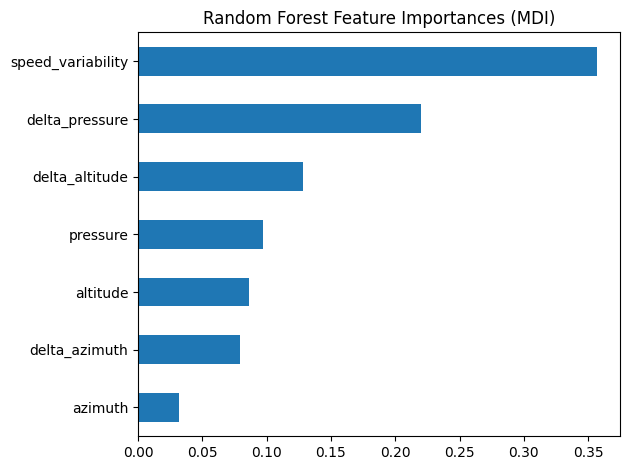

In [57]:
def plot_mdi_importance_plot(rf_pipeline):
    # https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html
    feature_names = rf_pipeline[:-1].get_feature_names_out()

    mdi_importances = pd.Series(
        rf_pipeline[-1].feature_importances_, index=feature_names
    ).sort_values(ascending=True)

    ax = mdi_importances.plot.barh()
    ax.set_title("Random Forest Feature Importances (MDI)")
    ax.figure.tight_layout()
plot_mdi_importance_plot(rf_pipeline)

In [58]:
def plot_permutation_importance_plot(pipeline):
    result = permutation_importance(
        pipeline, X_test, y_test, n_repeats=10, random_state=seed, n_jobs=-1
    )
    feature_names = pipeline[:-1].get_feature_names_out()
    # print(len(feature_names))
    # print(len(result.importances_mean))
    perm_imp_df = pd.DataFrame({'Feature': feature_names, 'Permutation Importance': result.importances_mean}).sort_values('Permutation Importance', ascending=False)
    plt.figure(figsize=(6, 6))
    plt.bar(perm_imp_df['Feature'], perm_imp_df['Permutation Importance'])
    plt.xlabel('Feature')
    plt.ylabel('Permutation Importance')
    plt.title('Permutation Feature Importance')
    plt.xticks(rotation=45, ha='right')  # Adjust rotation for better visibility
    plt.tight_layout()
    plt.show()
# plot_permutation_importance_plot(rf_pipeline)

In [59]:
explainer = shap.TreeExplainer(rf_model, feature_names=numerical_features)

In [60]:
# RF's predictions
rf_pipeline.predict(X_test)[:3]

array([1, 0, 0])

In [61]:
# Actual labels
y_test[:3]

8     1
50    0
43    0
Name: control_numeric, dtype: int64

The first id is a control patient and the model predicted this correctly.

The second and third ids are both non-control patients and the model predicted both correctly.

In [62]:
control_id = (0, 1) # First id that correctly predicted as a healthy patient
noncontrol_id = (1, 0) # Second id that was correctly predicted as a PD patient

In [63]:
feature_values, _ = rf_pipeline[:-1].fit_resample(X_train, y_train)
explanation = explainer(feature_values)
shap_values = explainer.shap_values(feature_values)

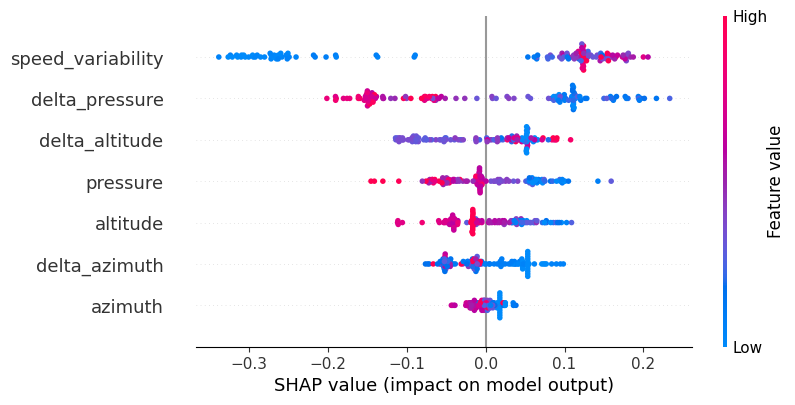

In [64]:
# Beeswarm plot for the PD patients
shap.plots.beeswarm(explanation[:,:,0], show=True)

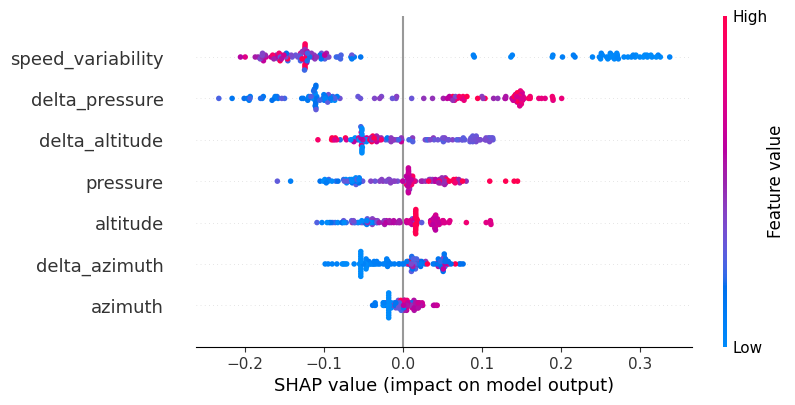

In [65]:
# Beeswarm plot for the healthy patients
shap.plots.beeswarm(explanation[:,:,1], show=True)

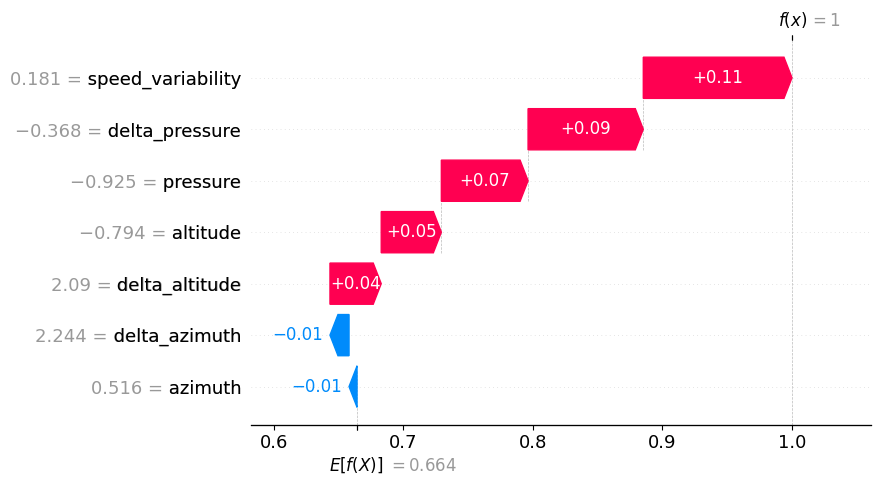

In [66]:
shap.plots.waterfall(explanation[noncontrol_id[0],:,noncontrol_id[1]])

In [67]:
shap.plots.force(explainer.expected_value[1], shap_values[noncontrol_id[0]][:,control_id[1]], X_test.iloc[noncontrol_id[0], :])

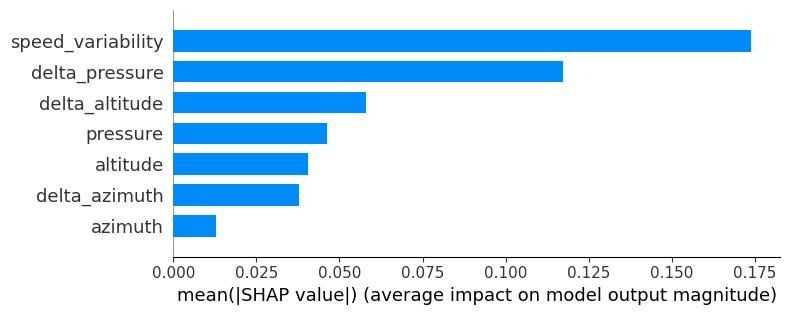

In [68]:
shap.summary_plot(shap_values=shap_values[..., 1], features=X_test, plot_type='bar', max_display=10, plot_size=0.25)

## Part 2: Performing with feature selection

In [69]:
rf_pipeline_fs = train_rf(True)
rf_model_fs = rf_pipeline_fs["classifier"]
feature_importances = rf_model_fs.feature_importances_

Train accuracy: 100.0%, Test accuracy: 96.0%


In [70]:
numerical_features_fs = rf_pipeline_fs[:-1].get_feature_names_out()
sorted(zip(list(feature_importances), numerical_features_fs), reverse=True) 

[(0.43376999039995273, 'speed_variability'),
 (0.25302343897621427, 'delta_pressure'),
 (0.1286091270582258, 'altitude'),
 (0.10818837498789675, 'delta_altitude'),
 (0.07640906857771056, 'pressure')]

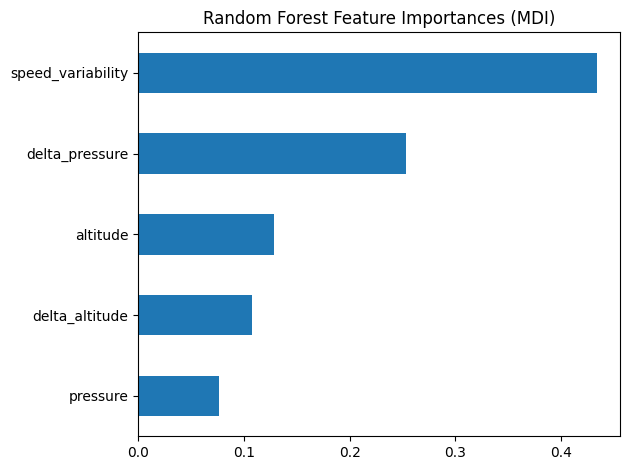

In [71]:
plot_mdi_importance_plot(rf_pipeline_fs)

In [72]:
explainer = shap.TreeExplainer(rf_model_fs, feature_names=numerical_features_fs)

In [73]:
# RF's predictions
rf_pipeline_fs.predict(X_test)[:3]

array([1, 0, 0])

In [74]:
# Actual labels
y_test[:3]

8     1
50    0
43    0
Name: control_numeric, dtype: int64

The first id is a control patient and the model predicted this correctly.

The second and third ids are both non-control patients and the model predicted both correctly.

In [75]:
control_id = (0, 1) # First id that correctly predicted as a healthy patient
noncontrol_id = (1, 0) # Second id that was correctly predicted as a PD patient

In [76]:
feature_values, _ = rf_pipeline_fs[:-1].fit_resample(X_train, y_train)
explanation = explainer(feature_values)
shap_values = explainer.shap_values(feature_values)

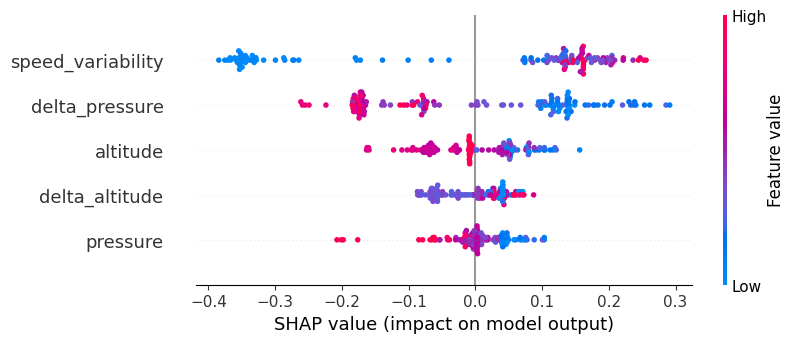

In [77]:
# Beeswarm plot for the PD patients
shap.plots.beeswarm(explanation[:,:,0], show=True)

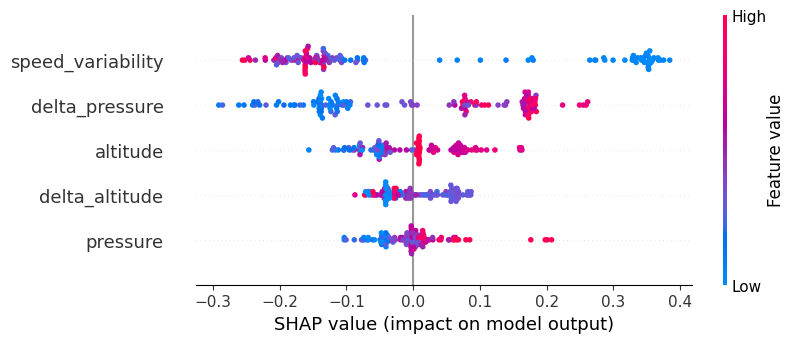

In [78]:
# Beeswarm plot for the healthy patients
shap.plots.beeswarm(explanation[:,:,1], show=True)

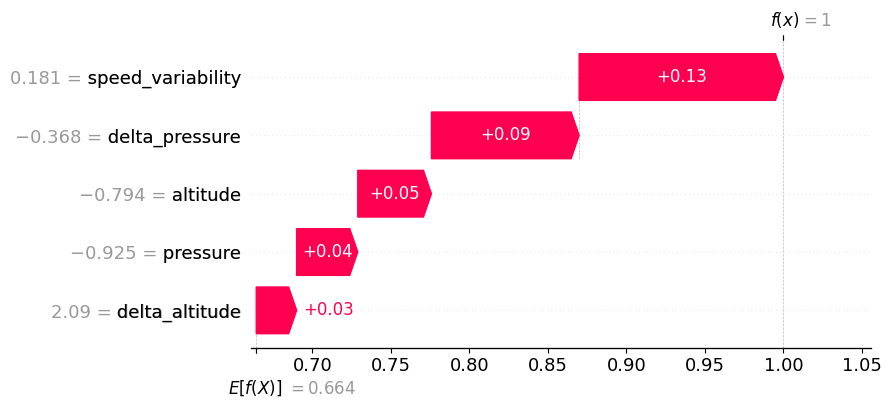

In [79]:
shap.plots.waterfall(explanation[noncontrol_id[0],:,noncontrol_id[1]])

In [80]:
X_test_fs = X_test[numerical_features_fs.tolist()]

In [81]:
shap.plots.force(explainer.expected_value[1], shap_values[0][:,0], X_test_fs.iloc[0, :], X_test_fs.columns.tolist())

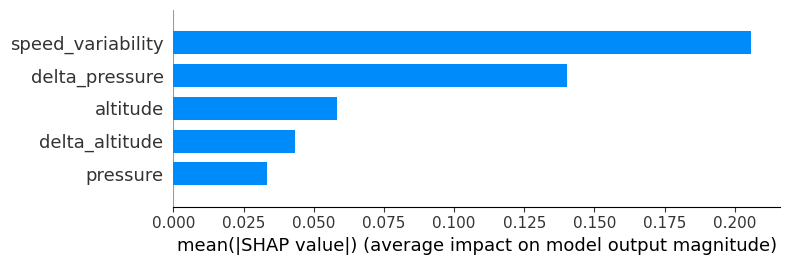

In [82]:
shap.summary_plot(shap_values=shap_values[..., 1], features=X_test_fs, plot_type='bar', max_display=10, plot_size=0.25)

## Discussion and Analysis

TODO